# Capstone - Alternative Cities for Living Analysis

## Introduction/Business Problem

With the current pandemic environment creating a WFH(Work From Home) environment for a majority of jobs, I wanted to analyze and create an engine that would allow looking at alternative locations for us to live that would allow us to be closer to venues we like (i.e. nice restaurants, parks, live music/theatre) and possibly closer to where our daughter may be attending college in 2021.  Since WFH allows us not to be in the cities where are companies are, we can begin to expand ideas on where we might want to relocate.  This could be utilized as the "engine" behind a GUI front-end for persons/families to pick their own city destinations and categories of venues for their decision-making process.  

## Data

I will be using the Foursquare API data to identify venues for 3 potential cities that may be where we might want to relocate based on our desire to be closer to our daughter's possible college choices and cities we've visited and like the general feel, but don't know much about the area, where we could live close to venues we like.  As stated, we don't need to look at schools, but do like parks, restaurants, and music/entertainment venues.  Also, we want to look at the housing costs, and the supply/demand of housing in that cities by zip code.  

To do this, I will use the Foursquare data to get the venues (and categories) for the cities of Kansas City, Missouri (we live in a suburb of Kansas City, but would love to move downtown if we stayed once our daughter was off to college), Fort Collins, CO, and Portland, OR.  

For the data on housing data, I will use data from Realtor.com (specifically, RDC_Inventory_Hotness_Metrics_Zip_History) that has current data (202004) on Housing inventory and hotness metric data that will supply the median_listing_prices, supply_score, demand_score, and median_listing_price_vs_us by zip code.  This data will allow us to look at the three cities and compare the median housing price, the comparison to the median price to rest of US (our current zip code is a +2 from the median price in US), and a gauge on the supply/demand index calculated by Realtors.com (high # up to 100 is level of either category) to gauge the housing market in that city.

All this data will allow us to compare zip codes(areas) in those cities that would be best suited for starting a search as well as compare cities if we needed to make a decision between cities.  Additional datapoints could be added but for sake of priorities, I limited to these data points identified above.  

Set up environment for doing foursquare lookup of data to create DFs

In [2]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

In [3]:
# First location Kansas City, MO
address = 'Kansas City, MO'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kansas City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Kansas City are 39.100105, -94.5781416.


In [4]:
CLIENT_ID = 'VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO' # Foursquare ID
CLIENT_SECRET = 'ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)


My credentials:
CLIENT_ID: VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO
CLIENT_SECRET: ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER


In [5]:
limit = 200 # limit of number of venues returned by Foursquare API
radius = 4000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=39.100105,-94.5781416&radius=4000&limit=200'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, limit)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=39.100105,-94.5781416&radius=4000&limit=200'

In [6]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5edf8c947828ae001b308d2d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Kansas City',
  'headerFullLocation': 'Kansas City',
  'headerLocationGranularity': 'city',
  'totalResults': 194,
  'suggestedBounds': {'ne': {'lat': 39.13610503600003,
    'lng': -94.53183911988859},
   'sw': {'lat': 39.06410496399997, 'lng': -94.6244440801114}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '568c885e498e68d35094a34a',
       'name': 'Zaina',
       'location': {'address': '1108 Grand Blvd',
        'crossStreet': 'btwn E 11th & 12th St',
        'lat': 39.100653504764765,
        'lng': -94.58086235424781,
    

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
venues = results['response']['groups'][0]['items']
    
KCnearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
KCnearby_venues =KCnearby_venues.loc[:, filtered_columns]

# filter the category for each row
KCnearby_venues['venue.categories'] = KCnearby_venues.apply(get_category_type, axis=1)

# clean columns
KCnearby_venues.columns = [col.split(".")[-1] for col in KCnearby_venues.columns]

KCnearby_venues.head(50)

,name,categories,lat,lng,postalCode
0,Zaina,Mediterranean Restaurant,39.100654,-94.580862,64106
1,Onelife Fitness,Gym,39.098829,-94.582885,64105
2,Reserve,New American Restaurant,39.100632,-94.580657,64106
3,Alamo Drafthouse Cinema,Movie Theater,39.097091,-94.583611,64105
4,Bristol Seafood Grill,Seafood Restaurant,39.097064,-94.582879,64106
5,Cosentino's Market Downtown,Supermarket,39.098676,-94.582964,64106
6,Polished Nail Salon,Salon / Barbershop,39.099604,-94.583052,64105
7,Arvest Bank Theatre at the Midland,Music Venue,39.098883,-94.583731,64105
8,Milwaukee Delicatessen Co.,Deli / Bodega,39.103463,-94.584324,64105
9,Messenger Coffee Co.,Coffee Shop,39.093469,-94.581503,64108


In [9]:
print('{} venues were returned by Foursquare.'.format(KCnearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [10]:
# create map of Kansas City using latitude and longitude values
map_KC = folium.Map(location=[latitude, longitude], zoom_start=20)

# add markers to map
for lat, lng, label in zip(KCnearby_venues['lat'], KCnearby_venues['lng'], KCnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=4,
        radius=10,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.7,
    ).add_to(map_KC)  
    
map_KC

In [11]:
# Second Location Fort Collins, CO
address = 'Fort Collins, CO'

geolocator = Nominatim(user_agent="foursquare_agent2")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Fort Collins are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Fort Collins are 40.5508527, -105.0668085.


In [12]:
limit = 200 # limit of number of venues returned by Foursquare API
radius = 4000 # define radius

# create URL
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=40.5508527,-105.0668085&radius=4000&limit=200'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, limit)
url2 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=40.5508527,-105.0668085&radius=4000&limit=200'

In [13]:
results = requests.get(url2).json()
results

{'meta': {'code': 200, 'requestId': '5edf8cadc546f3001beb205f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Fort Collins',
  'headerFullLocation': 'Fort Collins',
  'headerLocationGranularity': 'city',
  'totalResults': 230,
  'suggestedBounds': {'ne': {'lat': 40.58685273600003,
    'lng': -105.01951784911896},
   'sw': {'lat': 40.51485266399997, 'lng': -105.11409915088103}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c523c0fb6dabe9a341b0513',
       'name': 'Spring Creek Trail',
       'location': {'lat': 40.55048438318878,
        'lng': -105.07264283110844,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.5504

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
COnearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
COnearby_venues =COnearby_venues.loc[:, filtered_columns]

# filter the category for each row
COnearby_venues['venue.categories'] = COnearby_venues.apply(get_category_type, axis=1)

# clean columns
COnearby_venues.columns = [col.split(".")[-1] for col in COnearby_venues.columns]

COnearby_venues.head(50)

,name,categories,lat,lng,postalCode
0,Spring Creek Trail,Trail,40.550484,-105.072643,80525
1,Star of India,Indian Restaurant,40.549033,-105.076043,80525
2,Cinemark,Movie Theater,40.541727,-105.072320,80525
3,Maxline Brewing,Brewery,40.549659,-105.079270,80525
4,La Creperie,Breakfast Spot,40.549127,-105.076612,80525
5,Wilbur's Total Beverage,Liquor Store,40.559032,-105.078700,80525
6,Floyd's 99 Barbershop,Cosmetics Shop,40.559722,-105.077434,80525
7,Trader Joe's,Market,40.539738,-105.076067,NaN
8,Sprouts Farmers Market,Grocery Store,40.550660,-105.059595,80525
9,The Hop Grenade,Beer Bar,40.542131,-105.073163,80525


In [16]:
print('{} venues were returned by Foursquare.'.format(COnearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [17]:
# create map of Fort Collins using latitude and longitude values
map_CO = folium.Map(location=[latitude, longitude], zoom_start=20)

# add markers to map
for lat, lng, label in zip(COnearby_venues['lat'], COnearby_venues['lng'], COnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=3,
        radius=10,
        popup=label,
        color='red',
        fill_color='#0f0f0f',
        fill_opacity=0.7,
    ).add_to(map_CO)  
    
map_CO

In [18]:
# Third Location Portland, OR
address = 'Portland, OR'

geolocator = Nominatim(user_agent="foursquare_agent3")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Portland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Portland are 45.5202471, -122.6741949.


In [19]:
limit = 200 # limit of number of venues returned by Foursquare API
radius = 4000 # define radius

# create URL
url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=45.5202471,-122.6741949&radius=4000&limit=200'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, limit)
url3 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VFND3ZHY5XKTXP5BV2FNNGH4DAX0TWPJBIL01CMAPCXMPHNO&client_secret=ZWEBHLRGZDWUDULCV15X5GV4ZU21XOEW1VZHIB40ZBNPLPER&v=20180604&ll=45.5202471,-122.6741949&radius=4000&limit=200'

In [20]:
results = requests.get(url3).json()
results

{'meta': {'code': 200, 'requestId': '5edf8ad429ce6a001b757aeb'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Portland',
  'headerFullLocation': 'Portland',
  'headerLocationGranularity': 'city',
  'totalResults': 242,
  'suggestedBounds': {'ne': {'lat': 45.55624713600003,
    'lng': -122.62291044707251},
   'sw': {'lat': 45.484247063999966, 'lng': -122.7254793529275}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '56c031edcd10a9ebda494705',
       'name': 'Pine Street Market',
       'location': {'address': '126 SW 2nd Ave',
        'crossStreet': 'at Pine St',
        'lat': 45.52142080584174,
        'lng': -122.67249380990322,
      

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
venues = results['response']['groups'][0]['items']
    
ORnearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
ORnearby_venues =ORnearby_venues.loc[:, filtered_columns]

# filter the category for each row
ORnearby_venues['venue.categories'] = ORnearby_venues.apply(get_category_type, axis=1)

# clean columns
ORnearby_venues.columns = [col.split(".")[-1] for col in ORnearby_venues.columns]

ORnearby_venues.head(50)

,name,categories,lat,lng,postalCode
0,Pine Street Market,Food Court,45.521421,-122.672494,97204
1,"The Hi-Lo, Autograph Collection",Hotel,45.520349,-122.675134,97204
2,Kimpton Hotel Monaco Portland,Hotel,45.519876,-122.677367,97204
3,Lechon,Latin American Restaurant,45.521303,-122.670750,97204
4,Portland Burger,Burger Joint,45.520389,-122.673087,97204
5,Four Decades Jewelry,Jewelry Store,45.518984,-122.674805,97204
6,Lúc Lác Vietnamese Kitchen,Vietnamese Restaurant,45.516858,-122.675179,97204
7,Tiffany & Co.,Jewelry Store,45.517591,-122.676641,97204
8,Gov. Tom McCall Waterfront Park,Park,45.520631,-122.670293,97204
9,Barista,Coffee Shop,45.519179,-122.675083,97204


In [23]:
print('{} venues were returned by Foursquare.'.format(ORnearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [24]:
# create map of Portland using latitude and longitude values
map_OR = folium.Map(location=[latitude, longitude], zoom_start=20)

# add markers to map
for lat, lng, label in zip(ORnearby_venues['lat'], ORnearby_venues['lng'], ORnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=5,
        radius=10,
        popup=label,
        color='green',
        fill_color='#0f0f0f',
        fill_opacity=0.7,
    ).add_to(map_OR)  
    
map_OR

## Retrieving housing cost/affordability information from Realtor.com data


##### Convert data wrangled from Realtor.com website from a CSV file to a Pandas DF to be used in merging with the Foursquare data for the cities I've selected

In [25]:
# The code was removed by Watson Studio for sharing.

,month_date_yyyymm,postal_code,zip_name,nielsen_hh_rank,hotness_rank,hotness_rank_mm,hotness_rank_yy,hotness_score,supply_score,demand_score,median_days_on_market,median_days_on_market_mm,median_days_on_market_mm_day,median_days_on_market_yy,median_days_on_market_yy_day,median_days_on_market_vs_us,ldpviews_per_property_mm,ldpviews_per_property_yy,ldpviews_per_property_vs_us,median_listing_price,median_listing_price_mm,median_listing_price_yy,median_listing_price_vs_us
0,202004,22152,"springfield, va",3929,5,NaN,129.0,99.213373,100.000000,98.426745,7.0,1.3333,4.0,-0.2222,-2.0,-55.0,0.0240,0.0650,2.9583,544550.0,0.0837,0.0421,1.7016
1,202004,14425,"farmington, ny",8954,2986,-28.0,-1977.0,72.847310,99.992977,45.701643,10.0,-0.6364,-17.5,-0.4444,-8.0,-52.0,-0.1698,-0.4081,0.9167,280040.0,0.0000,0.0570,0.8750
2,202004,20165,"sterling, va",3042,232,-19.0,863.0,94.072201,99.978930,88.165473,11.5,0.0952,1.0,-0.3030,-5.0,-50.5,-0.1933,0.2176,1.8264,599800.0,0.0209,0.1056,1.8742
3,202004,24441,"grottoes, va",11705,1562,NaN,8155.0,82.413260,99.978930,64.847591,11.5,-0.8203,-52.5,-0.9139,-122.0,-50.5,-0.4986,-0.1916,1.2014,237500.0,0.0553,0.0725,0.7420
4,202004,80917,"colorado springs, co",2722,2,3.0,21.0,99.652339,99.964883,99.339795,12.5,0.5625,4.5,0.9231,6.0,-49.5,-0.3101,-0.1030,3.5069,316050.0,-0.0125,0.0533,0.9875


In [26]:
df_data_1.shape

(14216, 23)

Clean-up/Simplify the realty data as there are many of the 23 fields that we don't need when we merge with our foursquare data.

In [27]:
df_realty = df_data_1[['month_date_yyyymm', 'postal_code', 'hotness_rank', 'supply_score', 'demand_score', 'median_listing_price', 'median_listing_price_vs_us']]

In [28]:
df_realty.shape

(14216, 7)

In [29]:
df_realty = df_realty.astype({"month_date_yyyymm": str})

As dataset has historical data, only wanted to get the most current data for my analysis

In [30]:
cur_realty = df_realty[(df_realty.month_date_yyyymm == "202004")]
cur_realty.tail(30)


,month_date_yyyymm,postal_code,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us
14186,202004,41074,13604,0.203680,16.884394,513050.0,1.6031
14187,202004,12843,14213,0.196657,0.358196,199950.0,0.6247
14188,202004,12815,14062,0.161540,7.620452,284950.0,0.8903
14189,202004,12835,14066,0.161540,7.578312,229950.0,0.7184
14190,202004,12861,14181,0.161540,3.209720,398050.0,1.2438
14191,202004,12853,14207,0.161540,1.587302,184950.0,0.5778
14192,202004,12855,14214,0.161540,0.323079,185050.0,0.5781
14193,202004,48191,14194,0.154516,2.437140,363550.0,1.1359
14194,202004,68361,14198,0.147493,2.198342,139800.0,0.4367
14195,202004,62526,14087,0.140469,6.995365,94750.0,0.2959


In [31]:
cur_realty.shape

(14216, 7)

rename DF label to allow for merging with the Foursquare DF for each city 


In [32]:
cur_realty.rename(columns={'postal_code':'postalCode'}, inplace=True)
cur_realty.head()

,month_date_yyyymm,postalCode,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us
0,202004,22152,5,100.000000,98.426745,544550.0,1.7016
1,202004,14425,2986,99.992977,45.701643,280040.0,0.8750
2,202004,20165,232,99.978930,88.165473,599800.0,1.8742
3,202004,24441,1562,99.978930,64.847591,237500.0,0.7420
4,202004,80917,2,99.964883,99.339795,316050.0,0.9875


In [33]:
cur_realty = cur_realty.astype({"postalCode": str})

Convert postalCode to same datatype before merging

In [34]:
cur_realty.shape

(14216, 7)

In [35]:
KCnearby_venues.head()

,name,categories,lat,lng,postalCode
0,Zaina,Mediterranean Restaurant,39.100654,-94.580862,64106
1,Onelife Fitness,Gym,39.098829,-94.582885,64105
2,Reserve,New American Restaurant,39.100632,-94.580657,64106
3,Alamo Drafthouse Cinema,Movie Theater,39.097091,-94.583611,64105
4,Bristol Seafood Grill,Seafood Restaurant,39.097064,-94.582879,64106


Merge Kansas City venue foursquare data with the realty data to create new DF

In [36]:
KC_geo2 = pd.merge(KCnearby_venues, cur_realty, on='postalCode', how='left', indicator=True)
KC_geo2.head(10)

,name,categories,lat,lng,postalCode,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
0,Zaina,Mediterranean Restaurant,39.100654,-94.580862,64106,202004,10632.0,38.418317,21.625228,265050.0,0.8281,both
1,Onelife Fitness,Gym,39.098829,-94.582885,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
2,Reserve,New American Restaurant,39.100632,-94.580657,64106,202004,10632.0,38.418317,21.625228,265050.0,0.8281,both
3,Alamo Drafthouse Cinema,Movie Theater,39.097091,-94.583611,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
4,Bristol Seafood Grill,Seafood Restaurant,39.097064,-94.582879,64106,202004,10632.0,38.418317,21.625228,265050.0,0.8281,both
5,Cosentino's Market Downtown,Supermarket,39.098676,-94.582964,64106,202004,10632.0,38.418317,21.625228,265050.0,0.8281,both
6,Polished Nail Salon,Salon / Barbershop,39.099604,-94.583052,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
7,Arvest Bank Theatre at the Midland,Music Venue,39.098883,-94.583731,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
8,Milwaukee Delicatessen Co.,Deli / Bodega,39.103463,-94.584324,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
9,Messenger Coffee Co.,Coffee Shop,39.093469,-94.581503,64108,202004,6726.0,59.860936,45.856160,387050.0,1.2094,both


In [37]:
KC_geo2.shape

(100, 12)

In [38]:
KC_geo2.groupby('postalCode').count()

,name,categories,lat,lng,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
postalCode,,,,,,,,,,,
64101,1,1,1,1,0,0,0,0,0,0,1
64105,30,30,30,30,30,30,30,30,30,30,30
64106,29,29,29,29,29,29,29,29,29,29,29
64108,39,39,39,39,39,39,39,39,39,39,39
64120,1,1,1,1,0,0,0,0,0,0,1


In [39]:
print('There are {} unique categories.'.format(len(KC_geo2['categories'].unique())))

There are 67 unique categories.


Analyze venue categories in each KC ZipCoded

In [40]:
# one hot encoding
KC_onehot = pd.get_dummies(KC_geo2[['categories']], prefix="", prefix_sep="")

# add postalCode column back to dataframe
KC_onehot['postalCode'] = KC_geo2['postalCode']

# move postalCode column to the first column
fixed_columns = [KC_onehot.columns[-1]] + list(KC_onehot.columns[:-1])
KC_onehot = KC_onehot[fixed_columns]

KC_onehot.head()

,postalCode,American Restaurant,Antique Shop,Arcade,BBQ Joint,Bagel Shop,Bakery,Beer Garden,Brazilian Restaurant,Brewery,Bridge,Burrito Place,Café,Cajun / Creole Restaurant,Candy Store,Clothing Store,Cocktail Bar,Coffee Shop,Deli / Bodega,Distillery,Dive Bar,Dog Run,Ethiopian Restaurant,Farmers Market,French Restaurant,Gastropub,German Restaurant,Grocery Store,Gym,Health Food Store,Herbs & Spices Store,History Museum,Hotel,Ice Cream Shop,Italian Restaurant,Library,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Music Venue,New American Restaurant,Park,Performing Arts Venue,Pizza Place,Plaza,Poke Place,Print Shop,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Speakeasy,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,64106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,64105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,64106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,64105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,64106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
KC_onehot.shape

(100, 68)

In [42]:
KC_grouped = KC_onehot.groupby('postalCode').mean().reset_index()
KC_grouped

,postalCode,American Restaurant,Antique Shop,Arcade,BBQ Joint,Bagel Shop,Bakery,Beer Garden,Brazilian Restaurant,Brewery,Bridge,Burrito Place,Café,Cajun / Creole Restaurant,Candy Store,Clothing Store,Cocktail Bar,Coffee Shop,Deli / Bodega,Distillery,Dive Bar,Dog Run,Ethiopian Restaurant,Farmers Market,French Restaurant,Gastropub,German Restaurant,Grocery Store,Gym,Health Food Store,Herbs & Spices Store,History Museum,Hotel,Ice Cream Shop,Italian Restaurant,Library,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Music Venue,New American Restaurant,Park,Performing Arts Venue,Pizza Place,Plaza,Poke Place,Print Shop,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Speakeasy,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,64101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,64105,0.066667,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.066667,0.033333,0.000000,0.000000,0.0,0.033333,0.033333,0.000000,0.033333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.066667,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.033333,0.000000,0.066667,0.000000,0.066667,0.033333,0.033333,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000
2,64106,0.034483,0.000000,0.000000,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.034483,0.034483,0.000000,0.000000,0.0,0.034483,0.034483,0.034483,0.000000,0.000000,0.000000,0.000000,0.034483,0.034483,0.034483,0.000000,0.000000,0.034483,0.000000,0.000000,0.034483,0.034483,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103448,0.034483,0.000000,0.068966,0.034483,0.034483,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000
3,64108,0.025641,0.000000,0.025641,0.025641,0.000000,0.000000,0.000000,0.000000,0.051282,0.000000,0.000000,0.000000,0.000000,0.025641,0.025641,0.0,0.076923,0.000000,0.025641,0.000000,0.0,0.000000,0.000000,0.000000,0.025641,0.025641,0.000000,0.025641,0.000000,0.000000,0.051282,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.025641,0.000000,0.025641,0.000000,0.051282,0.051282,0.000000,0.025641,0.051282,0.000000,0.000000,0.025641,0.025641,0.000000,0.000000,0.000000,0.025641,0.000000,0.025641,0.000000,0.025641,0.000000,0.051282,0.051282,0.000000,0.025641,0.025641,0.000000,0.025641,0.025641
4,64120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
KC_grouped.shape

(5, 68)

In [44]:
num_top_venues = 5

for hood in KC_grouped['postalCode']:
    print("----"+hood+"----")
    temp = KC_grouped[KC_grouped['postalCode'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    

----64101----
                 venue  freq
0         Cocktail Bar   1.0
1  American Restaurant   0.0
2                 Park   0.0
3           Print Shop   0.0
4           Poke Place   0.0


----64105----
                 venue  freq
0  American Restaurant  0.07
1                 Café  0.07
2   Salon / Barbershop  0.07
3                 Park  0.07
4          Pizza Place  0.07


----64106----
                     venue  freq
0           Sandwich Place  0.10
1               Sports Bar  0.07
2  New American Restaurant  0.03
3        French Restaurant  0.03
4        Health Food Store  0.03


----64108----
              venue  freq
0       Coffee Shop  0.08
1    History Museum  0.05
2   Thai Restaurant  0.05
3  Tapas Restaurant  0.05
4           Brewery  0.05


----64120----
                 venue  freq
0              Dog Run   1.0
1  American Restaurant   0.0
2                 Park   0.0
3           Print Shop   0.0
4           Poke Place   0.0




Let's put this analysis into a Pandas dataframe

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating the dataframe and display the top 5 venues for each postalCode

In [46]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
KC_venues_sorted = pd.DataFrame(columns=columns)
KC_venues_sorted['postalCode'] = KC_grouped['postalCode']

for ind in np.arange(KC_grouped.shape[0]):
    KC_venues_sorted.iloc[ind, 1:] = return_most_common_venues(KC_grouped.iloc[ind, :], num_top_venues)
    
KC_venues_sorted.head()            

,postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,64101,Cocktail Bar,Coffee Shop,History Museum,Herbs & Spices Store,Health Food Store
1,64105,American Restaurant,Theater,Pizza Place,Café,Park
2,64106,Sandwich Place,Sports Bar,Italian Restaurant,New American Restaurant,Mediterranean Restaurant
3,64108,Coffee Shop,Pizza Place,New American Restaurant,Music Venue,Brewery
4,64120,Dog Run,Wine Shop,Coffee Shop,History Museum,Herbs & Spices Store


######   So this gives us a better visual of the categories of venues in each KC Zip Code - helpful to get a sense of areas we may want to focus on regarding housing 
######   as stated in the Introduction, we like Parks and Music venues but we also like Breweries and fun restaurants so we may begin looking at zipcode 64108 and then look at housing data

####  Now let's do the same analysis for Fort Collins, CO 

In [47]:
COnearby_venues.head()

,name,categories,lat,lng,postalCode
0,Spring Creek Trail,Trail,40.550484,-105.072643,80525
1,Star of India,Indian Restaurant,40.549033,-105.076043,80525
2,Cinemark,Movie Theater,40.541727,-105.072320,80525
3,Maxline Brewing,Brewery,40.549659,-105.079270,80525
4,La Creperie,Breakfast Spot,40.549127,-105.076612,80525


Merge Fort Collins venue foursquare data with the realty data 'cur_realty' (same realty data frame as all data for country is in same file) to create new DF for Ft. Collins

In [48]:
CO_geo2 = pd.merge(COnearby_venues, cur_realty, on='postalCode', how='left', indicator=True)
CO_geo2.head(10)

,name,categories,lat,lng,postalCode,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
0,Spring Creek Trail,Trail,40.550484,-105.072643,80525,202004,2644.0,92.4849,57.767945,462550.0,1.4453,both
1,Star of India,Indian Restaurant,40.549033,-105.076043,80525,202004,2644.0,92.4849,57.767945,462550.0,1.4453,both
2,Cinemark,Movie Theater,40.541727,-105.072320,80525,202004,2644.0,92.4849,57.767945,462550.0,1.4453,both
3,Maxline Brewing,Brewery,40.549659,-105.079270,80525,202004,2644.0,92.4849,57.767945,462550.0,1.4453,both
4,La Creperie,Breakfast Spot,40.549127,-105.076612,80525,202004,2644.0,92.4849,57.767945,462550.0,1.4453,both
5,Wilbur's Total Beverage,Liquor Store,40.559032,-105.078700,80525,202004,2644.0,92.4849,57.767945,462550.0,1.4453,both
6,Floyd's 99 Barbershop,Cosmetics Shop,40.559722,-105.077434,80525,202004,2644.0,92.4849,57.767945,462550.0,1.4453,both
7,Trader Joe's,Market,40.539738,-105.076067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
8,Sprouts Farmers Market,Grocery Store,40.550660,-105.059595,80525,202004,2644.0,92.4849,57.767945,462550.0,1.4453,both
9,The Hop Grenade,Beer Bar,40.542131,-105.073163,80525,202004,2644.0,92.4849,57.767945,462550.0,1.4453,both


In [49]:
CO_geo2.shape

(100, 12)

In [50]:
CO_geo2.groupby('postalCode').count()

,name,categories,lat,lng,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
postalCode,,,,,,,,,,,
80521,5,5,5,5,5,5,5,5,5,5,5
80523,1,1,1,1,0,0,0,0,0,0,1
80524,15,15,15,15,15,15,15,15,15,15,15
80525,64,64,64,64,64,64,64,64,64,64,64
80526,12,12,12,12,12,12,12,12,12,12,12


In [51]:
print('There are {} unique categories.'.format(len(CO_geo2['categories'].unique())))

There are 55 unique categories.


Analyze venue categories in each Fort Collins ZipCodes

In [52]:
# one hot encoding
CO_onehot = pd.get_dummies(CO_geo2[['categories']], prefix="", prefix_sep="")

# add postalCode column back to dataframe
CO_onehot['postalCode'] = CO_geo2['postalCode']

# move postalCode column to the first column
fixed_columns = [CO_onehot.columns[-1]] + list(CO_onehot.columns[:-1])
CO_onehot = CO_onehot[fixed_columns]

CO_onehot.head()

,postalCode,American Restaurant,Asian Restaurant,Bagel Shop,Bar,Beer Bar,Beer Garden,Bookstore,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Chinese Restaurant,Church,Coffee Shop,College Bookstore,Cosmetics Shop,Costume Shop,Deli / Bodega,Disc Golf,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Grocery Store,Gym,Gym / Fitness Center,Indian Restaurant,Italian Restaurant,Liquor Store,Market,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Noodle House,Park,Pet Store,Pizza Place,Sandwich Place,Seafood Restaurant,South Indian Restaurant,Sporting Goods Shop,Steakhouse,Taco Place,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,80525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,80525,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,80525,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
CO_onehot.shape

(100, 56)

In [54]:
CO_grouped = CO_onehot.groupby('postalCode').mean().reset_index()
CO_grouped

,postalCode,American Restaurant,Asian Restaurant,Bagel Shop,Bar,Beer Bar,Beer Garden,Bookstore,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Chinese Restaurant,Church,Coffee Shop,College Bookstore,Cosmetics Shop,Costume Shop,Deli / Bodega,Disc Golf,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Grocery Store,Gym,Gym / Fitness Center,Indian Restaurant,Italian Restaurant,Liquor Store,Market,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Noodle House,Park,Pet Store,Pizza Place,Sandwich Place,Seafood Restaurant,South Indian Restaurant,Sporting Goods Shop,Steakhouse,Taco Place,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,80521,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.00000,0.200000,0.000000,0.200000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,80523,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,80524,0.000000,0.000000,0.000000,0.0,0.000000,0.133333,0.000000,0.00000,0.0000,0.000000,0.066667,0.0,0.000000,0.000000,0.133333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.00000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.066667,0.0,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.133333,0.133333,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.066667,0.066667,0.000000
3,80525,0.015625,0.015625,0.015625,0.0,0.015625,0.000000,0.015625,0.03125,0.0625,0.015625,0.000000,0.0,0.046875,0.015625,0.093750,0.0,0.015625,0.015625,0.015625,0.015625,0.031250,0.015625,0.03125,0.015625,0.015625,0.000000,0.0625,0.03125,0.000000,0.015625,0.015625,0.015625,0.0,0.015625,0.0625,0.015625,0.03125,0.015625,0.015625,0.000000,0.000000,0.03125,0.015625,0.015625,0.015625,0.015625,0.015625,0.000000,0.015625,0.000000,0.015625,0.015625,0.015625,0.000000,0.015625
4,80526,0.000000,0.166667,0.083333,0.0,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.00000,0.000000,0.000000,0.083333,0.0000,0.00000,0.083333,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.083333,0.00000,0.000000,0.000000,0.166667,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000


In [55]:
CO_grouped.shape

(5, 56)

In [56]:
num_top_venues = 5

for hood in CO_grouped['postalCode']:
    print("----"+hood+"----")
    temp = CO_grouped[CO_grouped['postalCode'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----80521----
                       venue  freq
0                        Bar   0.2
1                       Park   0.2
2                    Theater   0.2
3  Cajun / Creole Restaurant   0.2
4                Pizza Place   0.2


----80523----
                  venue  freq
0     College Bookstore   1.0
1   American Restaurant   0.0
2  Gym / Fitness Center   0.0
3    Italian Restaurant   0.0
4          Liquor Store   0.0


----80524----
            venue  freq
0     Coffee Shop  0.13
1     Pizza Place  0.13
2  Sandwich Place  0.13
3     Beer Garden  0.13
4      Theme Park  0.07


----80525----
                venue  freq
0         Coffee Shop  0.09
1       Grocery Store  0.06
2  Mexican Restaurant  0.06
3             Brewery  0.06
4  Chinese Restaurant  0.05


----80526----
                  venue  freq
0      Asian Restaurant  0.17
1           Coffee Shop  0.17
2           Pizza Place  0.17
3            Bagel Shop  0.08
4  Gym / Fitness Center  0.08




Let's put this is a Pandas DF

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories2 = row.iloc[1:]
    row_categories_sorted2 = row_categories2.sort_values(ascending=False)
    
    return row_categories_sorted2.index.values[0:num_top_venues]

Create a Dataframe of the top 5 venues within the Fort Collins area (by postalCode)

In [58]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
CO_venues_sorted = pd.DataFrame(columns=columns)
CO_venues_sorted['postalCode'] = CO_grouped['postalCode']

for ind in np.arange(CO_grouped.shape[0]):
    CO_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CO_grouped.iloc[ind, :], num_top_venues)
    
CO_venues_sorted.head() 

,postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,80521,Park,Bar,Theater,Cajun / Creole Restaurant,Pizza Place
1,80523,College Bookstore,Yoga Studio,Church,Furniture / Home Store,Frozen Yogurt Shop
2,80524,Pizza Place,Sandwich Place,Beer Garden,Coffee Shop,Vietnamese Restaurant
3,80525,Coffee Shop,Grocery Store,Mexican Restaurant,Brewery,Chinese Restaurant
4,80526,Pizza Place,Coffee Shop,Asian Restaurant,Gym / Fitness Center,Donut Shop


######   So this gives us a better visual of the categories of venues in each Fort Collins Zip Code - helpful to get a sense of areas we may want to focus on regarding housing 
######   as stated in the Introduction, we like Parks and Music/Theater venues so we may begin looking at zipcode 80521 and then look at housing data

####  Now let's do the same analysis for Portland, OR 

In [59]:
ORnearby_venues.head()

,name,categories,lat,lng,postalCode
0,Pine Street Market,Food Court,45.521421,-122.672494,97204
1,"The Hi-Lo, Autograph Collection",Hotel,45.520349,-122.675134,97204
2,Kimpton Hotel Monaco Portland,Hotel,45.519876,-122.677367,97204
3,Lechon,Latin American Restaurant,45.521303,-122.670750,97204
4,Portland Burger,Burger Joint,45.520389,-122.673087,97204


Merge Portland venue foursquare data with the realty data 'cur_realty' (same realty data frame as all data for country is in same file) to create new DF for Portland

In [60]:
OR_geo2 = pd.merge(ORnearby_venues, cur_realty, on='postalCode', how='inner', indicator=True)
OR_geo2.head(10)

,name,categories,lat,lng,postalCode,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
0,Floating World Comics,Comic Shop,45.523740,-122.674538,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both
1,Powell's City of Books,Bookstore,45.523180,-122.681375,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both
2,Wailua Shave Ice,Dessert Shop,45.522464,-122.681684,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both
3,Powell's Books Gold Room,Bookstore,45.523182,-122.681416,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both
4,Powell's Books Rose Room,Bookstore,45.523484,-122.681471,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both
5,Powell's Books Orange Room,Bookstore,45.523560,-122.681888,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both
6,Mediterranean Exploration Company,Mediterranean Restaurant,45.525492,-122.684429,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both
7,Nuvrei Patisserie & Café,Bakery,45.526001,-122.681066,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both
8,Andina,Peruvian Restaurant,45.526463,-122.684632,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both
9,Barista,Coffee Shop,45.526954,-122.684357,97209,202004,10518,56.510746,5.330805,492000.0,1.5373,both


In [61]:
OR_geo2.shape

(83, 12)

In [62]:
OR_geo2.groupby('postalCode').count()

,name,categories,lat,lng,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
postalCode,,,,,,,,,,,
97201,4,4,4,4,4,4,4,4,4,4,4
97202,1,1,1,1,1,1,1,1,1,1,1
97205,14,14,14,14,14,14,14,14,14,14,14
97209,19,19,19,19,19,19,19,19,19,19,19
97210,4,4,4,4,4,4,4,4,4,4,4
97212,1,1,1,1,1,1,1,1,1,1,1
97214,36,36,36,36,36,36,36,36,36,36,36
97232,4,4,4,4,4,4,4,4,4,4,4


In [63]:
print('There are {} unique categories.'.format(len(OR_geo2['categories'].unique())))

There are 51 unique categories.


Analyze venue categories in each Portland ZipCodes

In [64]:
# one hot encoding
OR_onehot = pd.get_dummies(OR_geo2[['categories']], prefix="", prefix_sep="")

# add postalCode column back to dataframe
OR_onehot['postalCode'] = OR_geo2['postalCode']

# move postalCode column to the first column
fixed_columns = [OR_onehot.columns[-1]] + list(OR_onehot.columns[:-1])
OR_onehot = OR_onehot[fixed_columns]

OR_onehot.head()

,postalCode,American Restaurant,Art Gallery,Art Museum,Bakery,Bar,Bookstore,Brewery,Camera Store,Climbing Gym,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Cooking School,Deli / Bodega,Dessert Shop,Diner,Distillery,Donut Shop,Farmers Market,Food Truck,French Restaurant,Fried Chicken Joint,Grocery Store,Hotel,Ice Cream Shop,Israeli Restaurant,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant,Modern European Restaurant,Park,Peruvian Restaurant,Pizza Place,Poke Place,Pub,Ramen Restaurant,Russian Restaurant,Salon / Barbershop,Sandwich Place,Science Museum,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Street Food Gathering,Tea Room,Thai Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Yoga Studio
0,97209,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,97209,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,97209,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,97209,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,97209,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
OR_onehot.shape

(83, 52)

In [66]:
OR_grouped = OR_onehot.groupby('postalCode').mean().reset_index()
OR_grouped

,postalCode,American Restaurant,Art Gallery,Art Museum,Bakery,Bar,Bookstore,Brewery,Camera Store,Climbing Gym,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Cooking School,Deli / Bodega,Dessert Shop,Diner,Distillery,Donut Shop,Farmers Market,Food Truck,French Restaurant,Fried Chicken Joint,Grocery Store,Hotel,Ice Cream Shop,Israeli Restaurant,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant,Modern European Restaurant,Park,Peruvian Restaurant,Pizza Place,Poke Place,Pub,Ramen Restaurant,Russian Restaurant,Salon / Barbershop,Sandwich Place,Science Museum,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Street Food Gathering,Tea Room,Thai Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Yoga Studio
0,97201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,97202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
2,97205,0.071429,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.071429,0.00,0.00,0.071429,0.071429,0.000000,0.000000,0.00,0.071429,0.000000,0.0,0.000000,0.000000,0.00,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.071429,0.00,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.0,0.000000
3,97209,0.000000,0.000000,0.000000,0.105263,0.000000,0.210526,0.000000,0.052632,0.052632,0.000000,0.105263,0.052632,0.000000,0.00,0.00,0.052632,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.052632,0.00,0.000000,0.000000,0.000000,0.052632,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.052632
4,97210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.00,0.25,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.250000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,97212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,1.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
6,97214,0.000000,0.027778,0.000000,0.000000,0.055556,0.000000,0.083333,0.000000,0.000000,0.027778,0.111111,0.000000,0.027778,0.00,0.00,0.000000,0.000000,0.027778,0.027778,0.00,0.055556,0.055556,0.0,0.055556,0.000000,0.00,0.027778,0.027778,0.027778,0.000000,0.027778,0.000000,0.000000,0.000000,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.000000,0.00,0.000000,0.027778,0.027778,0.027778,0.027778,0.027778,0.0,0.000000
7,97232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.

In [67]:
OR_grouped.shape

(8, 52)

In [68]:
num_top_venues = 5

for hood in OR_grouped['postalCode']:
    print("----"+hood+"----")
    temp = OR_grouped[OR_grouped['postalCode'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----97201----
            venue  freq
0  Cooking School  0.25
1            Park  0.25
2  Farmers Market  0.25
3     Coffee Shop  0.25
4  Sandwich Place  0.00


----97202----
                           venue  freq
0  Vegetarian / Vegan Restaurant   1.0
1            American Restaurant   0.0
2             Salon / Barbershop   0.0
3      Latin American Restaurant   0.0
4       Mediterranean Restaurant   0.0


----97205----
                 venue  freq
0  American Restaurant  0.07
1          Coffee Shop  0.07
2   Italian Restaurant  0.07
3   Israeli Restaurant  0.07
4                  Pub  0.07


----97209----
         venue  freq
0    Bookstore  0.21
1  Coffee Shop  0.11
2       Bakery  0.11
3  Yoga Studio  0.05
4         Park  0.05


----97210----
                      venue  freq
0            Ice Cream Shop  0.25
1             Deli / Bodega  0.25
2             Grocery Store  0.25
3              Cocktail Bar  0.25
4  Mediterranean Restaurant  0.00


----97212----
                       v

Let's put this in a Pandas Dataframe

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories3 = row.iloc[1:]
    row_categories_sorted3 = row_categories3.sort_values(ascending=False)
    
    return row_categories_sorted3.index.values[0:num_top_venues]

Create a Dataframe of the top 5 venues within the Fort Collins area (by postalCode)

In [70]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
OR_venues_sorted = pd.DataFrame(columns=columns)
OR_venues_sorted['postalCode'] = OR_grouped['postalCode']

for ind in np.arange(OR_grouped.shape[0]):
    OR_venues_sorted.iloc[ind, 1:] = return_most_common_venues(OR_grouped.iloc[ind, :], num_top_venues)
    
OR_venues_sorted.head(10)

,postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,97201,Cooking School,Farmers Market,Park,Coffee Shop,Yoga Studio
1,97202,Vegetarian / Vegan Restaurant,Hotel,Grocery Store,Fried Chicken Joint,French Restaurant
2,97205,American Restaurant,Sandwich Place,Israeli Restaurant,Italian Restaurant,Diner
3,97209,Bookstore,Bakery,Coffee Shop,Yoga Studio,Climbing Gym
4,97210,Ice Cream Shop,Cocktail Bar,Deli / Bodega,Grocery Store,Bakery
5,97212,Fried Chicken Joint,Yoga Studio,Concert Hall,French Restaurant,Food Truck
6,97214,Coffee Shop,Brewery,French Restaurant,Grocery Store,Food Truck
7,97232,Coffee Shop,Spa,Hotel,Yoga Studio,Cooking School


### Comparison of the housing data for the 3 cities in this analysis

####  We will first combined the 3 cities data files and then show a bar chart with the median housing prices to compare all the zip codes to visually see how they compare

First we'll merge the data and create a new DF for comparison

In [71]:
frames = [KC_geo2, CO_geo2, OR_geo2]

US_geo2 = pd.concat(frames, sort=False)
US_geo2.head(10)

,name,categories,lat,lng,postalCode,month_date_yyyymm,hotness_rank,supply_score,demand_score,median_listing_price,median_listing_price_vs_us,_merge
0,Zaina,Mediterranean Restaurant,39.100654,-94.580862,64106,202004,10632.0,38.418317,21.625228,265050.0,0.8281,both
1,Onelife Fitness,Gym,39.098829,-94.582885,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
2,Reserve,New American Restaurant,39.100632,-94.580657,64106,202004,10632.0,38.418317,21.625228,265050.0,0.8281,both
3,Alamo Drafthouse Cinema,Movie Theater,39.097091,-94.583611,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
4,Bristol Seafood Grill,Seafood Restaurant,39.097064,-94.582879,64106,202004,10632.0,38.418317,21.625228,265050.0,0.8281,both
5,Cosentino's Market Downtown,Supermarket,39.098676,-94.582964,64106,202004,10632.0,38.418317,21.625228,265050.0,0.8281,both
6,Polished Nail Salon,Salon / Barbershop,39.099604,-94.583052,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
7,Arvest Bank Theatre at the Midland,Music Venue,39.098883,-94.583731,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
8,Milwaukee Delicatessen Co.,Deli / Bodega,39.103463,-94.584324,64105,202004,4275.0,74.146650,57.163928,190800.0,0.5961,both
9,Messenger Coffee Co.,Coffee Shop,39.093469,-94.581503,64108,202004,6726.0,59.860936,45.856160,387050.0,1.2094,both


In [72]:
US_geo2.shape

(283, 12)

Next we'll chart the data with assumption that the following postalCode prefixes equate to the following cities:  64XXX = Kansas City, 80XXX = Fort Collins, and 97XXX = Portland 

In [73]:
import matplotlib.pyplot as plt

In [79]:
US_geo2['postalCode'].unique()

array(['64106', '64105', '64108', '64120', '64101', '80525', nan, '80526',
       '80524', '80521', '80523', '97209', '97205', '97214', '97201',
       '97232', '97210', '97202', '97212'], dtype=object)

In [80]:
US_grouped = US_geo2[['postalCode', 'median_listing_price']]

In [82]:
housing = US_grouped.groupby(['postalCode'],as_index=True).mean()

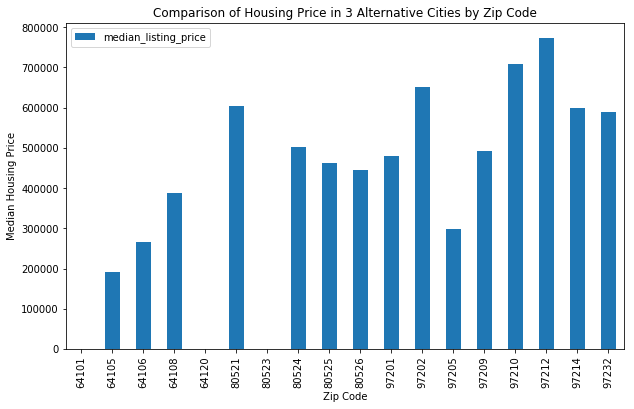

In [83]:
housing.plot(kind='bar', figsize=(10,6))

plt.xlabel('Zip Code')
plt.ylabel('Median Housing Price')
plt.title('Comparison of Housing Price in 3 Alternative Cities by Zip Code')
        
        
plt.show()
